## Get first appearance of covid per country

In [1]:
import pandas as pd

def create_new_dataframe_with_first_non_zero_column(csv_file_path, output_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Copy the first four columns to a new DataFrame
    new_df = df.iloc[:, :4].copy()
    
    # Initialize a list to store the new 'first_occurrence' column
    first_occurrence = []
    
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        found = False
        # Iterate over the columns, skipping the first four
        for col in df.columns[4:]:
            value = pd.to_numeric(row[col], errors='coerce')
            if not pd.isna(value) and value != 0:
                first_occurrence.append(col)
                found = True
                break
        if not found:
            first_occurrence.append(None)
    
    # Add the new column to the new DataFrame
    new_df['first_occurrence'] = first_occurrence
    
    # Save the new DataFrame to a new CSV file
    new_df.to_csv(output_file_path, index=False)

# Example usage
csv_file_path = './data/time_series_covid19_confirmed_global.csv'
output_file_path = './data/covidAppearance.csv'
create_new_dataframe_with_first_non_zero_column(csv_file_path, output_file_path)

## Order countries by date of Covid first appearance

In [2]:
csv_file_path = './data/covidAppearance.csv'
output_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')
df.sort_values(by=df.columns[4], inplace=True)

df.to_csv(output_file_path, index=False)

## Histogram with nr. of countries with first Covid appearance per date

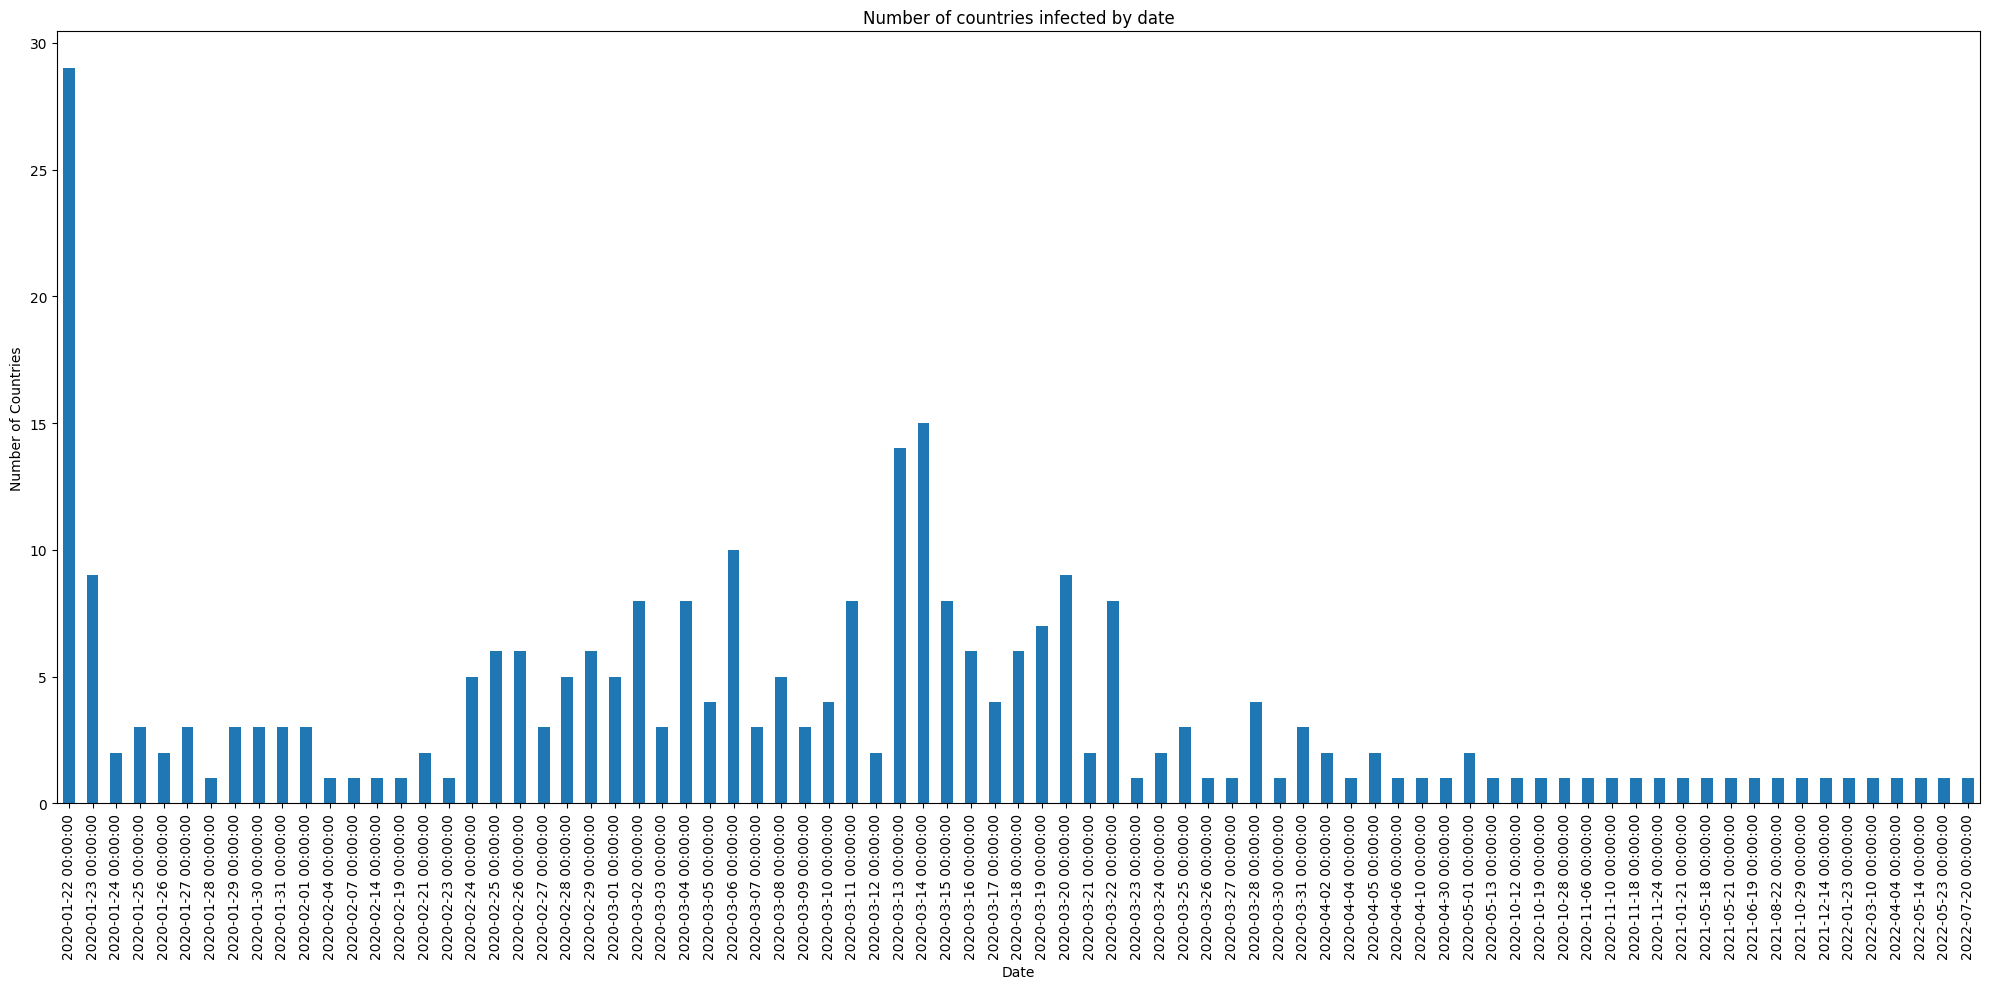

In [3]:
import matplotlib.pyplot as plt

csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')
    
# Count the occurrences of each date
date_counts = df.iloc[:, 4].value_counts().sort_index()
    
# Plot the histogram
plt.figure(figsize=(20, 10))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Number of Countries')
plt.title('Number of countries infected by date')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
df.head()

,Province/State,Country/Region,Lat,Long,first_occurrence
0,Henan,China,37.895700,114.904200,2020-01-22
1,Hubei,China,30.975600,112.270700,2020-01-22
2,Hunan,China,27.610400,111.708800,2020-01-22
3,Ningxia,China,37.269200,106.165500,2020-01-22
4,NaN,Thailand,15.870032,100.992541,2020-01-22


In [8]:
date_counts = df.iloc[:, 4].value_counts().sort_index()
date_counts

2020-01-22    29
2020-01-23     9
2020-01-24     2
2020-01-25     3
2020-01-26     2
              ..
2022-03-10     1
2022-04-04     1
2022-05-14     1
2022-05-23     1
2022-07-20     1
Name: first_occurrence, Length: 81, dtype: int64

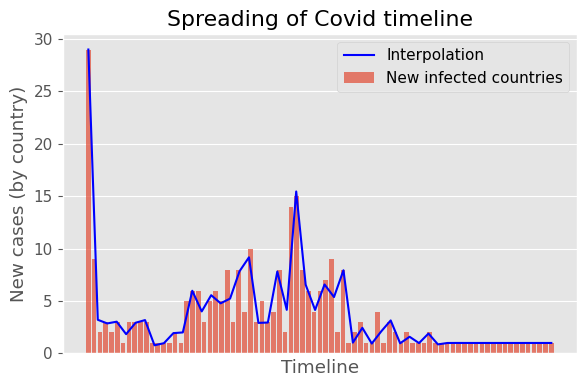

In [47]:
from scipy.interpolate import make_interp_spline
import numpy as np

dates = date_counts.index
counts = date_counts.values

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(6, 4))
plt.bar(dates, counts, alpha=0.9, label="New infected countries")

# interpolation
x_values = np.linspace(0, len(dates)-1, 50)
spl = make_interp_spline(np.arange(len(dates)), counts, k=3)
y_values = spl(x_values)
plt.plot(x_values, y_values, color='blue', linestyle='-', label='Interpolation')

plt.title('Spreading of Covid timeline')
plt.xlabel('Timeline')
plt.ylabel('New cases (by country)')
plt.xticks([])
plt.tight_layout() 
plt.grid(True)
plt.legend()
plt.show()

In [12]:
plt.rcParams.update({'font.size': 10}) # reset font size

## Create Covid graph

In [5]:
import pandas as pd
# Sample data: DataFrame with columns 'Country' and 'FirstCaseDate'
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

print(df.columns)

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'first_occurrence'], dtype='object')


# If Nan it probably means that there was no covid infection there (based on airports should be reported last?; provinces/states could be deleted?)

In [6]:
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)

print(df[pd.isna(df['first_occurrence'])])

      Province/State  Country/Region      Lat    Long first_occurrence
288  Channel Islands  United Kingdom  49.3723 -2.3644              NaN


In [7]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.express import colors
from plotly.colors import sample_colorscale

# Sample data: DataFrame with columns 'Country' and 'FirstCaseDate'
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
#df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

# Create a graph
G = nx.Graph()

# Add nodes
for _, row in df.iterrows():
    G.add_node(row['Country/Region'], province_state=row['Province/State'], first_case_date=row['first_occurrence'], Lat = row['Lat'], Long = row['Long'])



# Group countries by their first infection date and add edges between countries with the same date
grouped = df.groupby('first_occurrence')['Country/Region'].apply(list)
for date, countries in grouped.items():
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            G.add_edge(countries[i], countries[j], date=date)


# Generate a custom color palette with 81 distinct colors
unique_dates = df['first_occurrence'].unique()
num_colors = len(unique_dates)
color_scale = sample_colorscale('Viridis', [n / num_colors for n in range(num_colors)])

# Assign colors to each group (first case date)
color_map = {date: color_scale[i % num_colors] for i, date in enumerate(unique_dates)}


# Plot the graph
# Create node trace for scattergeo
node_trace = go.Scattergeo(
    lon=[G.nodes[node]['Long'] for node in G.nodes],
    lat=[G.nodes[node]['Lat'] for node in G.nodes],
    text=[f"{node}<br>First Case: {G.nodes[node]['first_case_date']}<br>Province or state: {G.nodes[node]['province_state']}" for node in G.nodes], #.date()
    mode='markers',
    marker=dict(
        size=[1 for node in G.nodes],
        color=[color_map[G.nodes[node]['first_case_date']] for node in G.nodes],
        opacity=0.7,
        colorscale='Viridis',
        colorbar=dict(title='First Case Date')
    )
)

"""
node_trace = go.Scattergeo(
    lon=[G.nodes[node]['Long'] for node in G.nodes],
    lat=[G.nodes[node]['Lat'] for node in G.nodes],
    text=[f"{node}<br>First Case: {G.nodes[node]['first_case_date'].date()}<br>Province or state: {G.nodes[node]['province_state']}" for node in G.nodes],
    mode='markers+text',
    marker=dict(size=[1 for node in G.nodes], color='blue', opacity=0.7),
    textposition="top center"
)
"""

# Create edge traces
edge_traces = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['Long'], G.nodes[edge[0]]['Lat']
    x1, y1 = G.nodes[edge[1]]['Long'], G.nodes[edge[1]]['Lat']
    #print(edge('date'))
    edge_color = color_map[G.nodes[edge[0]]['first_case_date']]
    edge_trace = go.Scattergeo(
        lon=[x0, x1, None],
        lat=[y0, y1, None],
        mode='lines',
        line=dict(width=0.5, color=edge_color),#dict(width=0.5, color='gray'),
        opacity=0.5
    )
    edge_traces.append(edge_trace)

# Create the figure
fig = go.Figure(data=edge_traces + [node_trace])

fig.update_layout(
    title='COVID-19 First Case Connections on World Map',
    showlegend=False,
    geo=dict(
        scope='world',
        projection_type='equirectangular',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)"
    )
)

fig.show()

ModuleNotFoundError: No module named 'plotly'

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.colors import sample_colorscale

# Use the correct renderer for your environment
#pio.renderers.default = 'notebook'  # Use 'notebook' for Jupyter Notebook, 'browser' for others

csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)

df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

df = df.dropna(subset=['first_occurrence'])

# Generate a custom color palette with 81 distinct colors
unique_dates = df['first_occurrence'].unique()
num_colors = len(unique_dates)
color_scale = sample_colorscale('Viridis', [n / num_colors for n in range(num_colors)])

# Assign colors to each group (first case date)
color_map = {date: color_scale[i % num_colors] for i, date in enumerate(unique_dates)}


# Create a scatter plot for nodes
node_trace = go.Scattergeo(
    lon=df['Long'],
    lat=df['Lat'],
    text=[f"{country}<br>First Case: {first_case}<br>Province or state: {provState}" for country, first_case, provState in zip(df['Country/Region'], df['first_occurrence'], df['Province/State'])],
    mode='markers',
    marker=dict(
        size=[(max(unique_dates) - first_case).days / 100 for first_case in df['first_occurrence']],  # Adjust size based on date difference
        color=[color_map[first_case] for first_case in df['first_occurrence']],
        opacity=0.7,
        colorscale='Viridis',
        colorbar=dict(title='First Case Date')
    )
)

# Create layout
layout = go.Layout(
    title='COVID-19 First Case Distribution',
    geo=dict(
        scope='world',
        projection_type='equirectangular',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)"
    )
)

# Create the figure
fig = go.Figure(data=node_trace, layout=layout)

# Show the figure
fig.show()

---

## Airport data (Create graph out of airports and routes)

In [ ]:
import pandas as pd
import numpy as np
import igraph as ig
import pickle
import pycountry
import os
import matplotlib.pyplot as plt

In [ ]:
airports_df = pd.read_csv('./data/airports.csv', sep=',', engine='python')
airports_df.head()

In [ ]:
routes_df = pd.read_csv('./data/routes.csv', sep=',', engine='python')
routes_df.head()

### Keep only EU countries (only if needed)

In [ ]:
def is_eu(country_name):
    try:
        country = pycountry.countries.lookup(country_name)
        return country.alpha_2 in ('AD', 'AL', 'AM', 'AT', 'AZ', 'BA', 'BE', 'BG', 'BY', 'CH', 'CY', 'CZ', 
                                   'DE', 'DK', 'EE', 'ES', 'FI', 'FO', 'FR', 'GB', 'GE', 'GI', 'GR', 'HR', 
                                   'HU', 'IE', 'IS', 'IT', 'KZ', 'LI', 'LT', 'LU', 'LV', 'MC', 'MD', 'ME', 
                                   'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK', 
                                   'SM', 'TR', 'UA', 'VA')
    except:
        return False

In [ ]:
airports_df = airports_df[[is_eu(r['Country']) for _, r in airports_df.iterrows()]]
airports_df = airports_df.reset_index(drop=True)
airports_df.head()

### Create graph

In [ ]:
graph = ig.Graph(directed=True)
id2index_map = {}

for index, row in airports_df.iterrows():
    id2index_map[row['Airport ID']] = index
    graph.add_vertex(name=row['Name'], ID=row['Airport ID'], lat=row['Latitude'], lon=row['Longitude'])

In [ ]:
edges = []
for index, row in routes_df.iterrows():
    if not row['Source airport ID'].strip().isdigit() or not row['Destination airport ID'].strip().isdigit():
        print("not an number:", row['Source airport ID'].strip().isdigit(), row['Destination airport ID'].strip().isdigit())
        continue
    
    aid = int(row['Source airport ID'])
    aid2 = int(row['Destination airport ID'])
    if 1328 in (aid, aid2):
        print(aid, aid2)
        
    if aid not in id2index_map or aid2 not in id2index_map:
        print("dont exist:", aid, aid2)
        continue
        
    edges.append((id2index_map[aid], id2index_map[aid2]))

graph.add_edges(edges)

In [ ]:
f'Nodes: {graph.vcount()}, Edges: {graph.ecount()}'

### Delete zero degree nodes (cant make predictions if airport has no connections)

In [ ]:
nodes_with_degree_zero = [vertex for vertex, degree in enumerate(graph.degree()) if degree == 0]
graph.delete_vertices(nodes_with_degree_zero)
len(nodes_with_degree_zero)

In [ ]:
f'Nodes: {graph.vcount()}, Edges: {graph.ecount()}'

### Keep only largest connected component

In [ ]:
sccs = graph.connected_components(mode='weak')
print(len(sccs))


# Get the sizes of each component
component_sizes = sccs.sizes()

for index in range(len(sccs)):
    print("Component:", index, "size:", component_sizes[index])


lcc = sccs.giant()
g = lcc

f'Nodes: {g.vcount()}, Edges: {g.ecount()}'


### Change to directed graph since multigraph doesnt add value (allready connected)

In [ ]:
from igraph import Graph


# Initialize a new directed graph
digraph = Graph(directed=True)
for v in g.vs:
    digraph.add_vertex(**v.attributes())

# Add edges to the new graph, avoiding duplicates
existing_edges = set()
for edge in g.es:
    source = edge.source
    target = edge.target
    if (source, target) not in existing_edges:
        digraph.add_edge(source, target)
        existing_edges.add((source, target))



f'Nodes: {digraph.vcount()}, Edges: {digraph.ecount()}'

#for node in digraph.vs:
#    print(node['lat'])

#print(g["lat"])

g = digraph


### Save graph

In [ ]:
with open("./data/graphWorld.pickle", "wb") as f:
    pickle.dump(g, f)

### Draw on world map (Not sure if good visualization)

In [ ]:
import pickle

with open("./data/graphWorld.pickle", "rb") as f:
    g = pickle.load(f)
    
g.vcount(), g.ecount(), g.is_directed()

In [ ]:
lats, lons, sizes = [], [], []
for node in g.vs:
    lats.append(node['lat'])
    lons.append(node['lon'])
    sizes.append(g.degree(node) / 5)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the world map from geopandas datasets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a figure and axis using cartopy with a specific projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographical features using cartopy
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the world map
world.boundary.plot(ax=ax, linewidth=1)

# Add a title
ax.set_title('World Map', fontsize=15)

ax.scatter(lons, lats, s=sizes, color='red', transform=ccrs.PlateCarree())

# Display the plot
plt.show()

---

## Perform node importance analysis

In [ ]:
import networkx as nx
import utils

import igraph as ig
import networkx as nx


G = g.to_networkx()

G = nx.convert_node_labels_to_integers(G, label_attribute=None)

#G = nx.DiGraph(G)

print(G)

In [ ]:
print(G.nodes[0])

### Network info

In [ ]:
import utils

utils.info(G, None, 10000) #Distance ne more avg (vsaj ne cez vse) ker ni strongly connected graf

### Degree Centrality

In [ ]:
from importlib import reload
reload(utils)

top_degree = utils.top_nodes(G, nx.degree_centrality(G), 'degree')

### In-degree centrality

In [ ]:
from importlib import reload
reload(utils)

top_degree = utils.top_nodes(G, nx.in_degree_centrality(G), 'degree')

### Out-degree centrality

In [ ]:
from importlib import reload
reload(utils)

top_degree = utils.top_nodes(G, nx.out_degree_centrality(G), 'degree')

### Clustering Coefficients

In [ ]:
top_clustering = utils.top_nodes(G, nx.clustering(G), 'clustering')

### mu-corrected clustering coefficient

In [ ]:
top_mu_clustering = utils.top_nodes(G, {i: c * (G.degree(i) - 1) for i, c in nx.clustering(G).items()}, '~μ-clustering')

### Eigenvector Centrality

In [ ]:
def eigenvector_centrality(G, eps = 1e-6):
    # Initialize eigenvector centrality score
    E = [1] * G.number_of_nodes()
    diff = 1
    # Repeat until the change in scores is less than a small value 'eps'
    while diff > eps:
        # Update scores based on neighbors' scores
        U = [sum([E[j] for j in G[i]]) for i in G.nodes()]
        # Normalize scores
        u = sum(U)
        U = [U[i] * len(G) / u for i in G.nodes()]
        # Calculate change in scores
        diff = sum([abs(E[i] - U[i]) for i in G.nodes()])
        # Use the new scores for the next iteration
        E = U
    return {i: E[i] for i in range(len(E))}

top_eigenVect = utils.top_nodes(G, eigenvector_centrality(G), 'eigenvector')

In [ ]:
top_eigenVect = utils.top_nodes(G, nx.eigenvector_centrality(G), 'eigenvector')

### PageRank

In [ ]:
def pagerank(G, alpha = 0.85, eps = 1e-6):
    P = [1 / len(G)] * len(G)
    diff = 1
    # Repeat until the change in scores is less than a small value 'eps'
    while diff > eps:
        # Update scores based on neighbors' scores and the number of their out-links
        U = [sum([P[j] * alpha / G.degree(j) for j in G[i]]) for i in G.nodes()]
        # Calculate a damping factor based on the 'alpha' parameter
        u = sum(U)
        # Apply the damping factor and ensure that the scores sum up to 1
        U = [U[i] + (1 - u) / len(G) for i in G.nodes()]
        # Calculate change in scores
        diff = sum([abs(P[i] - U[i]) for i in G.nodes()])
        P = U
    return {i: P[i] for i in range(len(P))}

top_pagerank = utils.top_nodes(G, pagerank(G), 'pagerank')

In [ ]:
top_pagerank = utils.top_nodes(G, nx.pagerank(G), 'pagerank')

### Closeness Centrality (probably not good for weak graph since it calculates distances for all nodes to all other nodes)

In [ ]:
top_closeness = utils.top_nodes(G, nx.closeness_centrality(G), 'closeness')

### Betweenness Centrality

In [ ]:
nodesBetweenness = utils.top_nodes(G, nx.betweenness_centrality(G), 'betweenness')#, n=len(G))

### Testing node order by degree (in-degree probably more important since youre interested in Covid coming in; But other ppl could travel to an airport by car (in) to continue by plane (out))

In [ ]:
degrees = dict(G.degree())

# Sort nodes by degree (in descending order)
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Print sorted nodes and their degrees
for node in sorted_nodes[:15]:
    print(f"ID:{node}, Name:{G.nodes[node]['name']}  - Degree: {degrees[node]}")

In [ ]:
degrees = dict(G.in_degree())

# Sort nodes by degree (in descending order)
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Print sorted nodes and their degrees
for node in sorted_nodes[:15]:
    print(f"ID:{node}, Name:{G.nodes[node]['name']}  - Degree: {degrees[node]}")

In [ ]:
degrees = dict(G.out_degree())

# Sort nodes by degree (in descending order)
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

# Print sorted nodes and their degrees
for node in sorted_nodes[:15]:
    print(f"ID:{node}, Name:{G.nodes[node]['name']}  - Degree: {degrees[node]}")